In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from dotenv import load_dotenv
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("talk")

In [2]:
load_dotenv("")
FREDkey = os.getenv("FREDkey")

In [30]:
varlist = ["WILL5000INDFC",
           "CPIAUCSL", 
           "IC4WSA",
           "TWEXBMTH",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "AHETPI",
           "PCE",
           "DEXJPUS",
           "DTWEXM",
           "DGS30",
           "DGS10",
           "DGS2",
           "DGS5",
           "DTB3",
           "MORTGAGE30US",
           "AAA",
           "BAA",
           "FEDFUNDS",
           "UMCSENT",  
           "CIVPART",
           "TCU",
           "UNRATE",
           "NFCI",
           "USRECDM",
           "GDPPOT",
           "GDPC1"
          ]

In [31]:
datalist=[]
for var in varlist:
    resp = requests.get(
        "https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type=json"
        .format(var, 
                FREDkey))
    df = pd.DataFrame(resp.json()['observations'])
    df.date = pd.to_datetime(df.date)
    df = df.loc[df.value!="."]
    df.value = df.value.astype(float)
    df.index = df.date
    df.drop(columns=["realtime_end", "realtime_start", "date"], axis=1, inplace=True)
    df.columns=[var]
    df= df.resample("1D").interpolate(method='linear')
    datalist.append(df)

In [134]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), datalist)

In [135]:
df_merged.shape

(63858, 28)

In [136]:
df_merged["2-10"] = df_merged.DGS10 - df_merged.DGS2
df_merged["10-30"] = df_merged.DGS30 - df_merged.DGS10
df_merged["positive_gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365) > 0
df_merged["gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365)

In [137]:
df_merged = df_merged.loc[df_merged.DGS30>-10].resample("1W").mean()

In [138]:
df_merged.tail()

,WILL5000INDFC,CPIAUCSL,IC4WSA,TWEXBMTH,INDPRO,IPMAN,HOUST,AHETPI,PCE,DEXJPUS,...,TCU,UNRATE,NFCI,USRECDM,GDPPOT,GDPC1,2-10,10-30,positive_gap,gap
date,,,,,,,,,,,,,,,,,,,,,
2019-07-14,141.997143,NaN,218714.285714,NaN,NaN,NaN,NaN,NaN,NaN,108.302857,...,NaN,NaN,-0.817959,0.0,18968.508696,NaN,0.238571,0.504286,0.0,-0.006372
2019-07-21,141.645714,NaN,214908.163265,NaN,NaN,NaN,NaN,NaN,NaN,107.935714,...,NaN,NaN,-0.821224,0.0,18976.284783,NaN,0.252857,0.517143,0.0,-0.006594
2019-07-28,142.752857,NaN,212387.755102,NaN,NaN,NaN,NaN,NaN,NaN,108.410000,...,NaN,NaN,-0.836531,0.0,18984.060870,NaN,0.227143,0.522857,0.0,-0.006817
2019-08-04,139.948571,NaN,212160.714286,NaN,NaN,NaN,NaN,NaN,NaN,108.204000,...,NaN,NaN,-0.847143,0.0,18991.836957,NaN,0.165714,0.530000,0.0,-0.007039
2019-08-11,136.662500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,18997.946739,NaN,0.127500,0.527500,0.0,-0.007214


In [139]:
percent = ["CPIAUCSL", 
           "IC4WSA",
           "TWEXBMTH",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "AHETPI",
           "PCE",
           "DEXJPUS",
           "DTWEXM"
          ]

In [140]:
actual = ["DGS30",
          "DGS10",
          "DGS2",
          "DGS5",
          "DTB3",
          "MORTGAGE30US",
          "AAA",
          "BAA",
          "FEDFUNDS",
          "UMCSENT",  
          "CIVPART",
          "TCU",
          "UNRATE",
          "NFCI",
          "2-10",
          "10-30"
         ]

In [141]:
def change(df, percent, actual, period):
    df_actual = df[actual].diff(period).fillna(method='ffill')

    df_percent = df[percent].pct_change(period).fillna(method='ffill')
    df_concat = pd.concat([df_actual, df_percent], axis=1)
    df_concat.columns = [str(col) + '_{}'.format(period) for col in df_concat.columns]
    return df_concat

In [142]:
week = change(df_merged, percent, actual, 1)
week_week = week.diff(1)
month = change(df_merged, percent, actual, 4)
month_month = month.diff(4)
three_m = change(df_merged, percent, actual, 13)
three_three = three_m.diff(13)
six_m = change(df_merged, percent, actual, 26)
six_six = six_m.diff(26)
one_y = change(df_merged, percent, actual, 52)

In [1107]:
X = pd.concat([week, 
               week_week, 
               month, 
               month_month, 
               three_m, 
               three_three, 
               six_m, 
               six_six, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_merged[actual].fillna(method="ffill").shift(1),
               df_merged[actual].fillna(method="ffill").shift(4),
               df_merged[actual].fillna(method="ffill").shift(13),
               df_merged[actual].fillna(method="ffill").shift(26),
               df_merged[actual].fillna(method="ffill").shift(52),
              ], axis=1)[52:]

In [1108]:
# X = pd.concat([week, 
#                week_week, 
#                month, 
#                month_month, 
#                three_m, 
#                three_three, 
#                six_m, 
#                six_six, 
#                one_y,
#               ], axis=1)[52:]

In [759]:
y1w = df_merged.positive_gap.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y1m = df_merged.positive_gap.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y3m = df_merged.positive_gap.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y6m = df_merged.positive_gap.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y12m = df_merged.positive_gap.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [760]:
# GDPC1y1w = df_merged.USREC.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y1m = df_merged.USREC.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y3m = df_merged.USREC.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y6m = df_merged.USREC.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y12m = df_merged.USREC.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [1109]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [1110]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

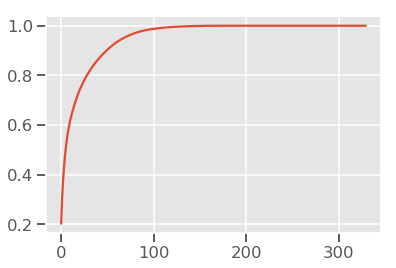

In [1111]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [1112]:
X_pca.shape

(2165, 330)

In [1113]:
y1w.shape

(2165,)

In [1115]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :30]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :30]
y1w_train = y1w[:int(X_pca.shape[0]*0.7)]
y1w_test = y1w[int(X_pca.shape[0]*0.7):]

In [62]:
clf = SVC()
param_grid = {"C" : np.linspace(.1, 20, num=11),
             "gamma" : np.linspace(10**-4, 5, num=6)}
grid_search = GridSearchCV(clf, param_grid, cv=5)
%timeit grid_search.fit(X_train, y1w_train)

35.8 s ± 451 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
grid_search.best_params_

{'C': 2.09, 'gamma': 0.0001}

In [64]:
clf = SVC(C=0.1, gamma=0.0001, probability=True)
clf.fit(X_train, y1w_train)
confusion_matrix(clf.predict(X_test), y1w_test)

array([[ 23,   0],
       [201, 426]])

In [65]:
clf.score(X_train, y1w_train)

0.6574257425742575

In [66]:
clf.score(X_test, y1w_test)

0.6907692307692308

In [67]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :30])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]

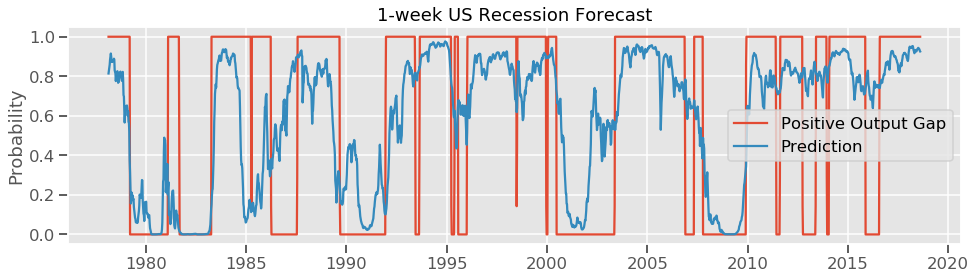

In [68]:
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-week US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1w_gap_svc")
plt.show()

In [69]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :30]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :30]
y1m_train = y1m[:int(X_pca.shape[0]*0.7)]
y1m_test = y1m[int(X_pca.shape[0]*0.7):]

In [70]:
clf = SVC()
param_grid = {"C" : np.linspace(.1, 20, num=11),
             "gamma" : np.linspace(10**-5, 5, num=6)}
grid_search = GridSearchCV(clf, param_grid, cv=5)
%timeit grid_search.fit(X_train, y1m_train)

34.6 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
grid_search.best_params_

{'C': 20.0, 'gamma': 1e-05}

In [78]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y1m_train)
confusion_matrix(clf.predict(X_test), y1m_test)

array([[117,  22],
       [107, 404]])

In [79]:
clf.score(X_train, y1m_train)

0.8409240924092409

In [80]:
clf.score(X_test, y1m_test)

0.8015384615384615

In [81]:
clf.predict_proba(X_pca[:, :30])

array([[0.05660739, 0.94339261],
       [0.0551683 , 0.9448317 ],
       [0.04704318, 0.95295682],
       ...,
       [0.4013045 , 0.5986955 ],
       [0.41286705, 0.58713295],
       [0.39040055, 0.60959945]])

In [82]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :30])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]

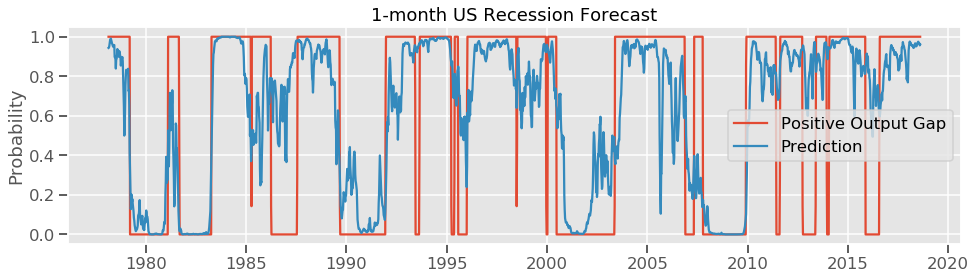

In [83]:
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1m_gap_svc")
plt.show()

In [84]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :30]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :30]
y3m_train = y3m[:int(X_pca.shape[0]*0.7)]
y3m_test = y3m[int(X_pca.shape[0]*0.7):]

In [85]:
clf = SVC()
param_grid = {"C" : np.linspace(.1, 20, num=11),
             "gamma" : np.linspace(10**-5, 5, num=6)}
grid_search = GridSearchCV(clf, param_grid, cv=5)
%timeit grid_search.fit(X_train, y3m_train)

39.8 s ± 2.51 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
grid_search.best_params_

{'C': 20.0, 'gamma': 1e-05}

In [88]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y3m_train)
confusion_matrix(clf.predict(X_test), y3m_test)

array([[109,  12],
       [119, 410]])

In [89]:
clf.score(X_train, y3m_train)

0.8237623762376237

In [90]:
clf.score(X_test, y3m_test)

0.7984615384615384

In [91]:
clf.predict_proba(X_pca[:, :30])

array([[0.15535728, 0.84464272],
       [0.13555894, 0.86444106],
       [0.11528569, 0.88471431],
       ...,
       [0.45679564, 0.54320436],
       [0.43296978, 0.56703022],
       [0.44059026, 0.55940974]])

In [93]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :30])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]

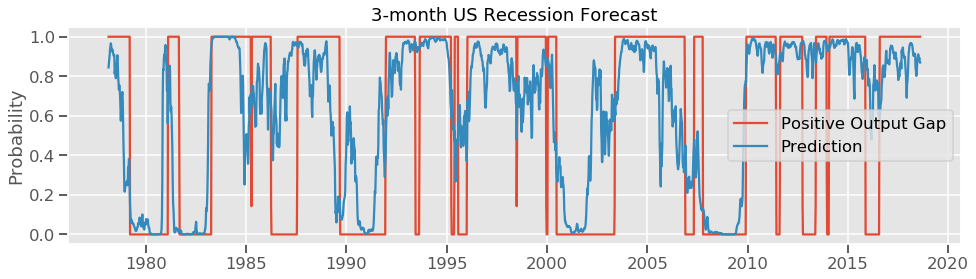

In [94]:
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("3-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/3m_gap_svc")
plt.show()

In [95]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :30]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :30]
y6m_train = y6m[:int(X_pca.shape[0]*0.7)]
y6m_test = y6m[int(X_pca.shape[0]*0.7):]

In [97]:
grid_search.best_params_

{'C': 20.0, 'gamma': 1e-05}

In [110]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y6m_train)
confusion_matrix(clf.predict(X_test), y6m_test)

array([[103,   0],
       [138, 409]])

In [111]:
clf.score(X_train, y6m_train)

0.834983498349835

In [112]:
clf.score(X_test, y6m_test)

0.7876923076923077

In [113]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :30])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]

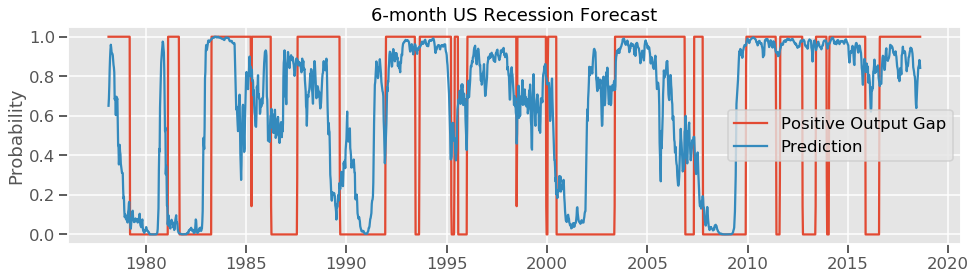

In [114]:
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_svc")
plt.show()

In [115]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :30]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :30]
y12m_train = y12m[:int(X_pca.shape[0]*0.7)]
y12m_test = y12m[int(X_pca.shape[0]*0.7):]

In [373]:
clf = SVC(C=38, gamma=0.00001, probability=True)
clf.fit(X_train, y12m_train)
confusion_matrix(clf.predict(X_test), y12m_test)

array([[ 91,  11],
       [156, 392]])

In [374]:
clf.score(X_train, y12m_train)

0.8356435643564356

In [375]:
clf.score(X_test, y12m_test)

0.7430769230769231

In [376]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :30])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]

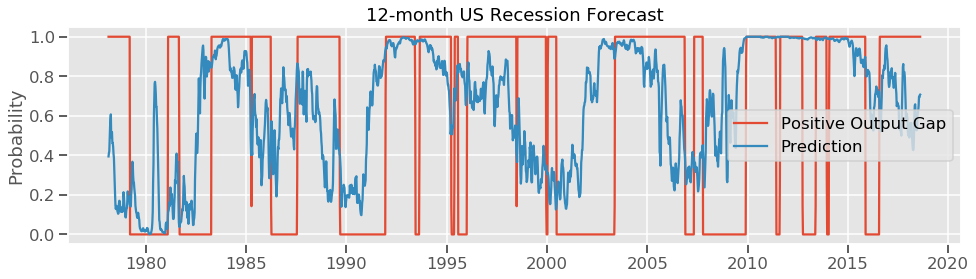

In [377]:
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svc")
plt.show()

In [1121]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :100]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :100]

In [1122]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score_dict = {}
for train_index, test_index in tscv.split(X_train):
    X_tr, X_tst = X_train[train_index], X_train[test_index]
    y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
    score = 0
    for c in [np.logspace(-10, 10, 2)]:
        for e in [np.logspace(-20, 0, 2)]:
            svm = SVR(C=c, epsilon=e, gamma="auto")
            svm.fit(X_tr, y_tr)
            if score < svm.score(X_tst, y_tst):
                score_dict[i] = [c, e, svm.score(X_tst, y_tst)]
    i += 1

TypeError: only size-1 arrays can be converted to Python scalars

In [1123]:
svm = SVR(C=100, epsilon=10**-2, gamma="auto")
svm.fit(X_train, g12m_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1124]:
svm.score(X_train, g12m_train)

0.7954561699226885

In [1125]:
svm.score(X_test, g12m_test)

0.027539248810495298

In [1126]:
pred = pd.DataFrame(svm.predict((X_pca[:])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]

ValueError: X.shape[1] = 330 should be equal to 100, the number of features at training time

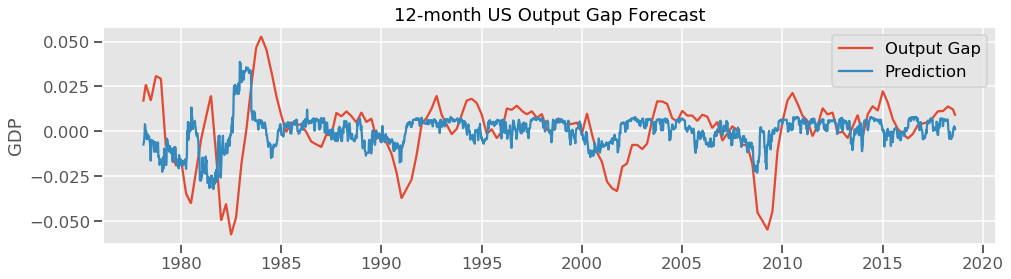

In [1127]:
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svm")
plt.show()

In [1129]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for mf in np.linspace(10, 100, 10):
#         for ne in np.linspace(10, 30, 11):
#             rfr = RandomForestRegressor(max_features=int(mf), n_estimators=int(ne))
#             rfr.fit(X_tr, y_tr)
#             if score < rfr.score(X_tst, y_tst):
#                 score_dict[i] = [mf, ne, rfr.score(X_tst, y_tst)]
#     i += 1

10.0 10.0 -2.0087160443632435
10.0 12.0 -1.790770759333221
10.0 14.0 -2.191994268061895
10.0 16.0 -1.0723166017472137
10.0 18.0 -1.1519151560712353
10.0 20.0 -1.2605635154384003
10.0 22.0 -1.5548987147597566
10.0 24.0 -1.1060149693747476
10.0 26.0 -1.1486357469300343
10.0 28.0 -1.6625211198006813
10.0 30.0 -1.0367027792633756
20.0 10.0 -1.0479259063843172
20.0 12.0 -1.3840079239112533
20.0 14.0 -0.6973347159028636
20.0 16.0 -1.0552297747411847
20.0 18.0 -1.1810649152355253
20.0 20.0 -1.0880707518128983
20.0 22.0 -0.7523906304944867
20.0 24.0 -1.1747847701640919
20.0 26.0 -0.9320908834786177
20.0 28.0 -0.9076254136967437
20.0 30.0 -1.0678892863383491
30.0 10.0 -0.5460970065711093
30.0 12.0 -1.6664325147189647
30.0 14.0 -0.8737746042228197
30.0 16.0 -0.9956459237341787
30.0 18.0 -0.7396876221644488
30.0 20.0 -0.9185043715932109
30.0 22.0 -0.753782301929133
30.0 24.0 -1.3692646163381554
30.0 26.0 -0.7764888305029789
30.0 28.0 -1.1186117967601241
30.0 30.0 -0.6099890300673689
40.0 10.0 -0.

50.0 30.0 -1.7849384031960873
60.0 10.0 -1.409056780170992
60.0 12.0 -1.3723632275984134
60.0 14.0 -0.9695976797051821
60.0 16.0 -1.1853639560223392
60.0 18.0 -0.5658003857073479
60.0 20.0 -0.8344472803746539
60.0 22.0 -1.4371547517982255
60.0 24.0 -2.0160079375151447
60.0 26.0 -0.7048976970695302
60.0 28.0 -1.1080803017941458
60.0 30.0 -1.2456306429244783
70.0 10.0 -0.2764551595992708
70.0 12.0 -0.5548352664175948
70.0 14.0 -1.0355931944682784
70.0 16.0 -0.6625845735881442
70.0 18.0 -0.6130520318380164
70.0 20.0 -0.9213612563428386
70.0 22.0 -1.1121688241958858
70.0 24.0 -1.9319811503376452
70.0 26.0 -1.3772106619427906
70.0 28.0 -0.688957468475625
70.0 30.0 -0.9969681575495224
80.0 10.0 -0.4222538258583757
80.0 12.0 -1.3122477530966865
80.0 14.0 -0.7784378721681737
80.0 16.0 -0.9261773837114042
80.0 18.0 -0.7069499851669154
80.0 20.0 -1.257204057956057
80.0 22.0 -1.7633114776698533
80.0 24.0 -1.037349320827695
80.0 26.0 -1.6437804313440378
80.0 28.0 -0.8650086462984391
80.0 30.0 -0.7

100.0 28.0 -2.598780350342422
100.0 30.0 -3.6952013191423525


In [1130]:
score_dict

{2: [100.0, 30.0, 0.1593315958390914]}

In [1132]:
rfr = RandomForestRegressor(max_features=50, n_estimators=20, max_depth=10, min_samples_leaf=30, random_state=0)
rfr.fit(X_train, g12m_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=50, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=30, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [1133]:
rfr.score(X_train, g12m_train)

0.7215616532884706

In [1134]:
rfr.score(X_test, g12m_test)

0.24906457143504546

In [1137]:
pred = pd.DataFrame(rfr.predict((X_pca[:, :100])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]

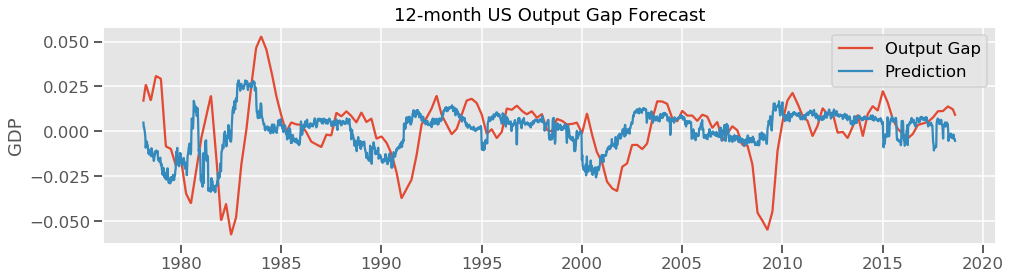

In [1138]:
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_rfr")
plt.show()

In [1139]:
xgr = XGBRegressor(max_depth=2, learning_rate=0.1, )
xgr.fit(X_train, g12m_train)

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[01:10:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [1140]:
xgr.score(X_train, g12m_train)

0.8316112246861576

In [1141]:
xgr.score(X_test, g12m_test)

0.07984919663590273

In [1144]:
pred = pd.DataFrame(xgr.predict((X_pca[:, :100])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]

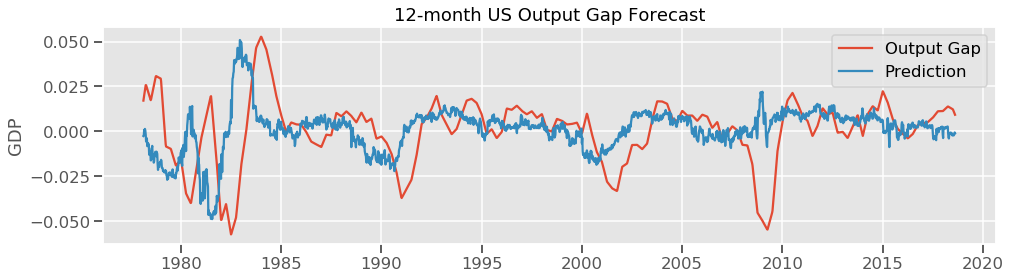

In [1145]:
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_xgr")
plt.show()